In [1]:
#Mount from drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
#Importing necessary modules
import os
import pickle
import glob

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer

import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, save_model, load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image

In [2]:
#File directory
filedir = "./drive/My Drive/CZ4042/Assignment 2/"
filedir = "./"

In [3]:
# This is required when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [4]:
# Fixed, no need change
def load_data(file):
    filename = filedir+file
    with open(filename, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    #data = np.array(data, dtype=np.float32) / 255
    features = samples['data'].reshape((len(samples['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = np.array(labels, dtype=np.int32)
    return features, labels


In [5]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def display_stats(cifar10_dataset_folder_path, sample_id):
    features, labels = load_data(cifar10_dataset_folder_path)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(1))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)
    return sample_image

In [6]:
def CNNmodel(num_ch_c1, num_ch_c2, use_dropout=False):
    #Model for CNN
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(3072, )))
    model.add(layers.Reshape(target_shape=(32, 32, 3), input_shape=(3072,)))
    #A convolution  layer 𝐶1 with 50 channels,window  size  9x9,  VALID  padding,  and  ReLU activation
    model.add(layers.Conv2D(num_ch_c1, 9, activation='relu', input_shape=(None, None, 3)))
    #A max pooling layer 𝑆1 with a pooling window of size 2x2, stride = 2,and VALID padding
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
    #Add dropout layer
    if use_dropout:
      model.add(layers.Dropout(0.5))
    #A  convolution  layer 𝐶2 with 60 channels, window  size  5x5,  VALID  padding,  and  ReLU activation
    model.add(layers.Conv2D(num_ch_c2, 5, activation='relu', input_shape=(None, None, 3)))
    #A max pooling layer 𝑆2 with a pooling window of size 2x2, stride = 2,and VALID padding
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
    #Add dropout layer
    if use_dropout:
      model.add(layers.Dropout(0.5))
    #A fully-connected layer 𝐹1 of size 300 with no activation
    model.add(layers.Dense(300))
    model.add(layers.Flatten())
    #A fully-connected layer 𝐹2 of size 10 with Softmax activation
    model.add(layers.Dense(10, use_bias=True, input_shape=(300,),activation='softmax'))  # Softmax
    return model

In [7]:
def main(num_ch_c1, num_ch_c2, epochs = 1000, optimizer_ = 'SGD', use_dropout = False):
    seed = 0
    np.random.seed(seed)
    tf.random.set_seed(seed)

    #epochs = 10 #Test functionality
    batch_size = 128  # Fixed
    learning_rate = 0.001

    #model = make_model(num_ch_c1, num_ch_c2, use_dropout)
    model = CNNmodel(num_ch_c1, num_ch_c2, use_dropout)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    if optimizer_ == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_ == 'SGD-momentum':  # Question 3(a)
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=1.0)
    elif optimizer_ == 'RMSProp':  # Question 3(b)
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_ == 'Adam':  # Question 3(c)
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError(f'You do not need to handle [{optimizer_}] in this project.')

    # Training and test
    x_train, y_train = load_data('data_batch_1')
    x_test, y_test = load_data('test_batch_trim')

    # Training
    model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test))

    # Create folder to store models and results
    if not os.path.exists(f'{filedir}models'):
        os.mkdir(f'{filedir}models')
    if not os.path.exists(f'{filedir}results'):
        os.mkdir(f'{filedir}results')

    # Save model
    if use_dropout:
        model.save(f'{filedir}models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_dropout')
    else:
        model.save(f'{filedir}models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_no_dropout')

    #Save History
    if not os.path.exists(f'{filedir}trainHistory'):
        os.mkdir(f'{filedir}trainHistory')
    #Save History
    try:
      with open(f'{filedir}trainHistory/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_trainHistoryDict.json', 'wb') as file_pi:
          pickle.dump(history.history, file_pi)
    except:
      print("Storing history failed!")
    # Save the plot for losses
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Test')
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    if use_dropout:
        plt.savefig(
            f'{filedir}results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_dropout_loss.pdf')
    else:
        plt.savefig(
            f'{filedir}results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_no_dropout_loss.pdf'
        )
    plt.close()

    # Save the plot for accuracies
    train_acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    if use_dropout:
        plt.savefig(
            f'{filedir}results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_dropout_accuracy.pdf'
        )
    else:
        plt.savefig(
            f'{filedir}results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_no_dropout_accuracy.pdf'
        )
    plt.close()

In [ ]:
if __name__ == '__main__':
    main(50,60)

- val_loss: 1.9926 - val_accuracy: 0.4645
Epoch 871/1000
79/79 [==============================] - 12s 146ms/step - loss: 1.7206 - accuracy: 0.7358 - val_loss: 1.9936 - val_accuracy: 0.4640
Epoch 872/1000
79/79 [==============================] - 12s 147ms/step - loss: 1.7206 - accuracy: 0.7360 - val_loss: 1.9930 - val_accuracy: 0.4685
Epoch 873/1000
79/79 [==============================] - 12s 146ms/step - loss: 1.7206 - accuracy: 0.7360 - val_loss: 1.9937 - val_accuracy: 0.4645
Epoch 874/1000
79/79 [==============================] - 12s 146ms/step - loss: 1.7205 - accuracy: 0.7360 - val_loss: 1.9935 - val_accuracy: 0.4665
Epoch 875/1000
79/79 [==============================] - 12s 146ms/step - loss: 1.7205 - accuracy: 0.7360 - val_loss: 1.9941 - val_accuracy: 0.4680
Epoch 876/1000
79/79 [==============================] - 12s 152ms/step - loss: 1.7205 - accuracy: 0.7360 - val_loss: 1.9932 - val_accuracy: 0.4635
Epoch 877/1000
79/79 [==============================] - 12s 152ms/step - los

In [8]:
#Load everything
def load_everything(num_ch_c1, num_ch_c2, epochs = 1000, optimizer_ = 'SGD', use_dropout = False):
    seed = 0
    np.random.seed(seed)
    tf.random.set_seed(seed)

    batch_size = 128  # Fixed
    learning_rate = 0.001

    #model = make_model(num_ch_c1, num_ch_c2, use_dropout)
    model = CNNmodel(num_ch_c1, num_ch_c2, use_dropout)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    if optimizer_ == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_ == 'SGD-momentum':  # Question 3(a)
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=1.0)
    elif optimizer_ == 'RMSProp':  # Question 3(b)
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_ == 'Adam':  # Question 3(c)
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError(f'You do not need to handle [{optimizer_}] in this project.')

    # Training and test
    x_train, y_train = load_data('data_batch_1')
    x_test, y_test = load_data('test_batch_trim')

    #Load Model
    model = load_model(f'{filedir}models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_no_dropout/')

    #Load History
    history = pickle.load(open(f'{filedir}trainHistory/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_trainHistoryDict.json','rb'))

    return model, history

In [11]:
# Training and test
x_train, y_train = load_data('data_batch_1')
x_test, y_test = load_data('test_batch_trim')

model, history = load_everything(50,60)

## Q1 b

In [ ]:
#Initiating Model from input tensor and list of output tensor

# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# summarize output shape
	print(i, layer.name, layer.output.shape)

0 reshape (None, 32, 32, 3)
1 conv2d (None, 24, 24, 50)
2 max_pooling2d (None, 12, 12, 50)
3 conv2d_1 (None, 8, 8, 60)
4 max_pooling2d_1 (None, 4, 4, 60)
5 dense (None, 4, 4, 300)
6 flatten (None, 4800)
7 dense_1 (None, 10)


In [ ]:
# redefine models to output right after the convo and pool layers
c1_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
c2_model = Model(inputs=model.inputs, outputs=model.layers[3].output)
p1_model = Model(inputs=model.inputs, outputs=model.layers[2].output)
p2_model = Model(inputs=model.inputs, outputs=model.layers[4].output)

#Save the four layers in one
layer_outputs = [c1_model, c2_model, p1_model, p2_model] 
layer_outputs = [layer.output for layer in model.layers] 
# Extracts the outputs of the top 12 layers

# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 


Stats of batch #1:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 1005
Label Counts of [1](AUTOMOBILE) : 974
Label Counts of [2](BIRD) : 1032
Label Counts of [3](CAT) : 1016
Label Counts of [4](DEER) : 999
Label Counts of [5](DOG) : 937
Label Counts of [6](FROG) : 1030
Label Counts of [7](HORSE) : 1001
Label Counts of [8](SHIP) : 1025
Label Counts of [9](TRUCK) : 981

Example of Image 1:
Image - Min Value: 5 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


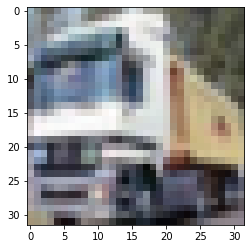

In [ ]:
# Test Image 1
sample_id = 1
test_img = display_stats('data_batch_1', sample_id)

In [ ]:
#Running model in predictive mode
activations = activation_model.predict(x_test) 
# Returns a list of five Numpy arrays: one array per layer activation

In [ ]:
#Print activation shape
c1_activation = activations[1]
print("c1: "+str(c1_activation.shape))
c2_activation = activations[3]
print("c2: "+str(c2_activation.shape))
p1_activation = activations[2]
print("p1: "+str(p1_activation.shape))
p2_activation = activations[4]
print("p2: "+str(p2_activation.shape))

c1: (2000, 24, 24, 50)
c2: (2000, 8, 8, 60)
p1: (2000, 12, 12, 50)
p2: (2000, 4, 4, 60)


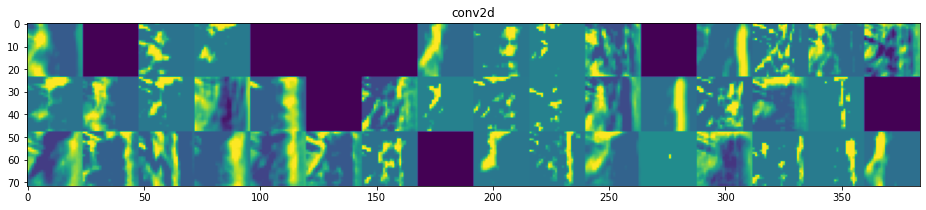

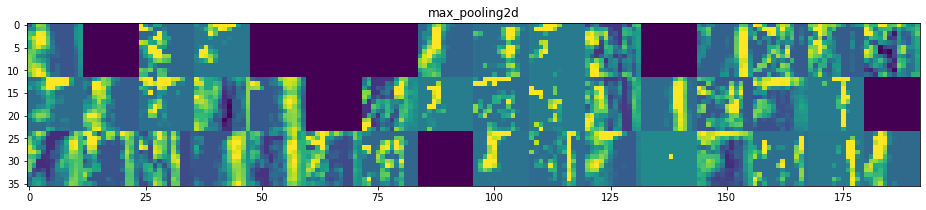

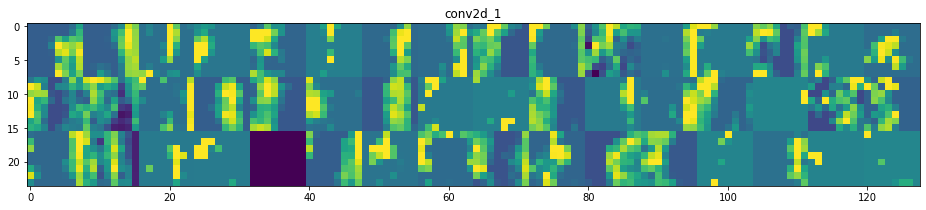

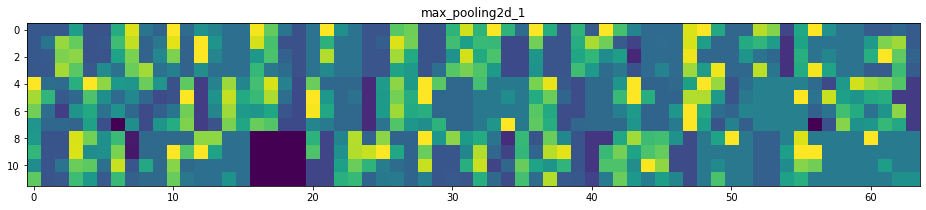

In [ ]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

images_per_row = 16

target_layers = ['conv2d','max_pooling2d','conv2d_1','max_pooling2d_1']

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    if layer_name in target_layers:
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                :, :,
                                                col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                            row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Q2

In [ ]:
#To Grid Search to find optimal c1, c2
# c1 = 10,30,50,70,90
# c2 = 20,40,60,80,100

#For this optimal search, we will train the model for only 500 epochs

In [ ]:
param_grid = dict(num_ch_c1=[10,30,50,70,90], num_ch_c2=[20,40,60,80,100])
scorers = {
        'accuracy_score': make_scorer(accuracy_score)
        }

#Convert model to estimator
keras_estimator = keras.estimator.model_to_estimator(
    keras_model=model)

grid = GridSearchCV(estimator=keras_estimator, param_grid=param_grid,scoring=scorers, n_jobs=-1, cv=3, refit="accuracy_score")
grid_result = grid.fit(x_train, y_train)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.


AttributeError: ignored

In [ ]:
#Combi 1
c1 = 10
c2 = 20
if __name__ == '__main__':
    main(c1, c2, epochs = 500)

Epoch 1/500
79/79 [==============================] - 13s 166ms/step - loss: 2.3258 - accuracy: 0.1255 - val_loss: 2.3310 - val_accuracy: 0.1240
Epoch 2/500
79/79 [==============================] - 13s 165ms/step - loss: 2.2923 - accuracy: 0.1601 - val_loss: 2.2982 - val_accuracy: 0.1580
Epoch 3/500
79/79 [==============================] - 13s 166ms/step - loss: 2.2774 - accuracy: 0.1771 - val_loss: 2.2854 - val_accuracy: 0.1670
Epoch 4/500
79/79 [==============================] - 13s 167ms/step - loss: 2.2652 - accuracy: 0.1892 - val_loss: 2.2634 - val_accuracy: 0.1910
Epoch 5/500
79/79 [==============================] - 13s 167ms/step - loss: 2.2610 - accuracy: 0.1930 - val_loss: 2.3115 - val_accuracy: 0.1445
Epoch 6/500
79/79 [==============================] - 13s 168ms/step - loss: 2.2559 - accuracy: 0.1978 - val_loss: 2.3086 - val_accuracy: 0.1465
Epoch 7/500
79/79 [==============================] - 14s 172ms/step - loss: 2.2537 - accuracy: 0.1997 - val_loss: 2.2599 - val_accuracy:

In [ ]:
#Combi 2
c1 = 10
c2 = 40
if __name__ == '__main__':
    main(c1, c2, epochs = 500)

Epoch 1/500
79/79 [==============================] - 12s 149ms/step - loss: 2.3266 - accuracy: 0.1302 - val_loss: 2.2946 - val_accuracy: 0.1585
Epoch 2/500
79/79 [==============================] - 12s 148ms/step - loss: 2.2863 - accuracy: 0.1680 - val_loss: 2.2721 - val_accuracy: 0.1810
Epoch 3/500
79/79 [==============================] - 12s 147ms/step - loss: 2.2669 - accuracy: 0.1881 - val_loss: 2.2903 - val_accuracy: 0.1645
Epoch 4/500
79/79 [==============================] - 12s 147ms/step - loss: 2.2582 - accuracy: 0.1949 - val_loss: 2.3154 - val_accuracy: 0.1375
Epoch 5/500
79/79 [==============================] - 12s 148ms/step - loss: 2.2486 - accuracy: 0.2057 - val_loss: 2.2370 - val_accuracy: 0.2160
Epoch 6/500
79/79 [==============================] - 12s 148ms/step - loss: 2.2391 - accuracy: 0.2152 - val_loss: 2.2837 - val_accuracy: 0.1715
Epoch 7/500
79/79 [==============================] - 12s 148ms/step - loss: 2.2360 - accuracy: 0.2194 - val_loss: 2.2903 - val_accuracy:

In [ ]:
#Combi 3
c1 = 10
c2 = 60
if __name__ == '__main__':
    main(c1, c2, 500)

Epoch 1/500
79/79 [==============================] - 17s 211ms/step - loss: 2.3259 - accuracy: 0.1281 - val_loss: 2.3240 - val_accuracy: 0.1320
Epoch 2/500
79/79 [==============================] - 12s 153ms/step - loss: 2.2891 - accuracy: 0.1672 - val_loss: 2.2825 - val_accuracy: 0.1740
Epoch 3/500
79/79 [==============================] - 12s 153ms/step - loss: 2.2846 - accuracy: 0.1705 - val_loss: 2.3090 - val_accuracy: 0.1490
Epoch 4/500
79/79 [==============================] - 12s 153ms/step - loss: 2.2819 - accuracy: 0.1758 - val_loss: 2.3126 - val_accuracy: 0.1475
Epoch 5/500
79/79 [==============================] - 12s 154ms/step - loss: 2.2805 - accuracy: 0.1757 - val_loss: 2.3563 - val_accuracy: 0.1040
Epoch 6/500
79/79 [==============================] - 12s 154ms/step - loss: 2.2674 - accuracy: 0.1885 - val_loss: 2.2773 - val_accuracy: 0.1785
Epoch 7/500
79/79 [==============================] - 12s 154ms/step - loss: 2.2508 - accuracy: 0.2033 - val_loss: 2.3018 - val_accuracy:

In [ ]:
#Combi 4
c1 = 10
c2 = 80
if __name__ == '__main__':
    main(c1, c2, 500)

Epoch 1/500
79/79 [==============================] - 13s 162ms/step - loss: 2.3230 - accuracy: 0.1322 - val_loss: 2.3061 - val_accuracy: 0.1495
Epoch 2/500
79/79 [==============================] - 13s 169ms/step - loss: 2.3024 - accuracy: 0.1507 - val_loss: 2.2786 - val_accuracy: 0.1780
Epoch 3/500
79/79 [==============================] - 13s 163ms/step - loss: 2.2819 - accuracy: 0.1719 - val_loss: 2.2955 - val_accuracy: 0.1635
Epoch 4/500
79/79 [==============================] - 13s 162ms/step - loss: 2.2739 - accuracy: 0.1812 - val_loss: 2.3425 - val_accuracy: 0.1160
Epoch 5/500
79/79 [==============================] - 13s 162ms/step - loss: 2.2717 - accuracy: 0.1841 - val_loss: 2.3200 - val_accuracy: 0.1380
Epoch 6/500
79/79 [==============================] - 13s 164ms/step - loss: 2.2893 - accuracy: 0.1673 - val_loss: 2.3086 - val_accuracy: 0.1500
Epoch 7/500
79/79 [==============================] - 13s 164ms/step - loss: 2.2866 - accuracy: 0.1709 - val_loss: 2.3090 - val_accuracy:

In [ ]:
#Combi 5
c1 = 10
c2 = 100
if __name__ == '__main__':
    main(c1, c2, 500)

Epoch 1/500
79/79 [==============================] - 14s 171ms/step - loss: 2.3361 - accuracy: 0.1177 - val_loss: 2.3205 - val_accuracy: 0.1375
Epoch 2/500
79/79 [==============================] - 14s 172ms/step - loss: 2.3089 - accuracy: 0.1469 - val_loss: 2.3025 - val_accuracy: 0.1535
Epoch 3/500
79/79 [==============================] - 14s 172ms/step - loss: 2.2964 - accuracy: 0.1590 - val_loss: 2.3197 - val_accuracy: 0.1390
Epoch 4/500
79/79 [==============================] - 13s 169ms/step - loss: 2.2882 - accuracy: 0.1683 - val_loss: 2.2742 - val_accuracy: 0.1825
Epoch 5/500
79/79 [==============================] - 14s 176ms/step - loss: 2.2863 - accuracy: 0.1705 - val_loss: 2.2676 - val_accuracy: 0.1880
Epoch 6/500
79/79 [==============================] - 14s 177ms/step - loss: 2.2783 - accuracy: 0.1783 - val_loss: 2.2831 - val_accuracy: 0.1735
Epoch 7/500
79/79 [==============================] - 15s 186ms/step - loss: 2.2725 - accuracy: 0.1838 - val_loss: 2.2976 - val_accuracy:

In [ ]:
#Combi 6
c1 = 30
c2 = 20
if __name__ == '__main__':
    main(c1, c2, 500)

Epoch 1/500
79/79 [==============================] - 18s 223ms/step - loss: 2.3631 - accuracy: 0.0964 - val_loss: 2.3585 - val_accuracy: 0.1020
Epoch 2/500
79/79 [==============================] - 18s 229ms/step - loss: 2.3517 - accuracy: 0.1065 - val_loss: 2.3551 - val_accuracy: 0.1050
Epoch 3/500
79/79 [==============================] - 18s 231ms/step - loss: 2.3277 - accuracy: 0.1288 - val_loss: 2.3324 - val_accuracy: 0.1240
Epoch 4/500
79/79 [==============================] - 18s 229ms/step - loss: 2.3068 - accuracy: 0.1504 - val_loss: 2.2855 - val_accuracy: 0.1685
Epoch 5/500
79/79 [==============================] - 18s 224ms/step - loss: 2.2996 - accuracy: 0.1586 - val_loss: 2.2802 - val_accuracy: 0.1785
Epoch 6/500
79/79 [==============================] - 18s 226ms/step - loss: 2.2781 - accuracy: 0.1786 - val_loss: 2.2734 - val_accuracy: 0.1845
Epoch 7/500
79/79 [==============================] - 17s 218ms/step - loss: 2.2725 - accuracy: 0.1840 - val_loss: 2.2822 - val_accuracy:

In [ ]:
#Combi 7
c1 = 30
c2 = 40
if __name__ == '__main__':
    main(c1, c2, 500)

Epoch 1/500
79/79 [==============================] - 14s 173ms/step - loss: 2.3301 - accuracy: 0.1283 - val_loss: 2.3352 - val_accuracy: 0.1240
Epoch 2/500
79/79 [==============================] - 13s 170ms/step - loss: 2.3119 - accuracy: 0.1472 - val_loss: 2.3612 - val_accuracy: 0.1000
Epoch 3/500
12/79 [===>..........................] - ETA: 9s - loss: 2.3570 - accuracy: 0.1042

KeyboardInterrupt: ignored

In [ ]:
#Combi 8
c1 = 30
c2 = 60
if __name__ == '__main__':
    main(c1, c2, 500)

Epoch 1/500
 7/79 [=>............................] - ETA: 11s - loss: 2.3664 - accuracy: 0.0926

KeyboardInterrupt: ignored

In [ ]:
#Combi 9
c1 = 30
c2 = 80
if __name__ == '__main__':
    main(c1, c2, 500)

In [ ]:
#Combi 10
c1 = 30
c2 = 100
if __name__ == '__main__':
    main(c1, c2, 500)

In [ ]:
#Combi 11
c1 = 50
c2 = 20
if __name__ == '__main__':
    main(c1, c2, 500)

In [ ]:
#Combi 12
c1 = 50
c2 = 40
if __name__ == '__main__':
    main(c1, c2, 500)

In [ ]:
#Combi 13
c1 = 50
c2 = 60
if __name__ == '__main__':
    main(c1, c2, 500)

In [ ]:
#Combi 14
c1 = 50
c2 = 80
if __name__ == '__main__':
    main(c1, c2, 500)

In [ ]:
#Combi 15
c1 = 50
c2 = 100
if __name__ == '__main__':
    main(c1, c2, 500)

In [ ]:
#Combi 16
c1 = 70
c2 = 20
if __name__ == '__main__':
    main(c1, c2, 500)

In [ ]:
#Combi 17
c1 = 70
c2 = 40
if __name__ == '__main__':
    main(c1, c2, 500)

In [ ]:
#Combi 18
c1 = 70
c2 = 60
if __name__ == '__main__':
    main(c1, c2, 500)

In [ ]:
#Combi 19
c1 = 70
c2 = 80
if __name__ == '__main__':
    main(c1, c2, 500)

In [10]:
#Combi 20
c1 = 70
c2 = 100
if __name__ == '__main__':
    main(c1, c2, 500)

.9764 - accuracy: 0.4886 - val_loss: 2.1248 - val_accuracy: 0.3290
Epoch 80/500
79/79 [==============================] - 21s 264ms/step - loss: 1.9796 - accuracy: 0.4844 - val_loss: 2.1076 - val_accuracy: 0.3490
Epoch 81/500
79/79 [==============================] - 21s 263ms/step - loss: 1.9736 - accuracy: 0.4909 - val_loss: 2.1033 - val_accuracy: 0.3500
Epoch 82/500
79/79 [==============================] - 21s 261ms/step - loss: 1.9744 - accuracy: 0.4903 - val_loss: 2.1049 - val_accuracy: 0.3470
Epoch 83/500
79/79 [==============================] - 21s 261ms/step - loss: 1.9721 - accuracy: 0.4929 - val_loss: 2.1526 - val_accuracy: 0.3010
Epoch 84/500
79/79 [==============================] - 21s 263ms/step - loss: 1.9740 - accuracy: 0.4918 - val_loss: 2.1263 - val_accuracy: 0.3270
Epoch 85/500
79/79 [==============================] - 21s 262ms/step - loss: 1.9748 - accuracy: 0.4903 - val_loss: 2.1045 - val_accuracy: 0.3525
Epoch 86/500
79/79 [==============================] - 21s 260ms

KeyboardInterrupt: 

In [ ]:
#Combi 21
c1 = 90
c2 = 20
if __name__ == '__main__':
    main(c1, c2, 500)

In [ ]:
#Combi 22
c1 = 90
c2 = 40
if __name__ == '__main__':
    main(c1, c2, 500)

In [ ]:
#Combi 23
c1 = 90
c2 = 60
if __name__ == '__main__':
    main(c1, c2, 500)

In [ ]:
#Combi 24
c1 = 90
c2 = 80
if __name__ == '__main__':
    main(c1, c2, 500)

In [ ]:
#Combi 25
c1 = 90
c2 = 100
if __name__ == '__main__':
    main(c1, c2, 500)

Epoch 1/500
79/79 [==============================] - 44s 563ms/step - loss: 2.3440 - accuracy: 0.1148 - val_loss: 2.3248 - val_accuracy: 0.1340
Epoch 2/500
79/79 [==============================] - 45s 564ms/step - loss: 2.3171 - accuracy: 0.1414 - val_loss: 2.3515 - val_accuracy: 0.1090
Epoch 3/500
79/79 [==============================] - 45s 564ms/step - loss: 2.3122 - accuracy: 0.1459 - val_loss: 2.3200 - val_accuracy: 0.1395
Epoch 4/500
79/79 [==============================] - 45s 567ms/step - loss: 2.3064 - accuracy: 0.1511 - val_loss: 2.2968 - val_accuracy: 0.1595
Epoch 5/500
79/79 [==============================] - 45s 571ms/step - loss: 2.2906 - accuracy: 0.1671 - val_loss: 2.3218 - val_accuracy: 0.1380
Epoch 6/500
79/79 [==============================] - 45s 575ms/step - loss: 2.2843 - accuracy: 0.1715 - val_loss: 2.2807 - val_accuracy: 0.1760
Epoch 7/500
79/79 [==============================] - 45s 570ms/step - loss: 2.2701 - accuracy: 0.1866 - val_loss: 2.2678 - val_accuracy:

In [12]:
model = KerasClassifier(build_fn=CNNmodel, verbose=0)
#To Grid Search to find optimal c1, c2
c1 = [10,30,50,70,90]
c2 = [20,40,60,80,100]

param_grid = {'num_ch_c1':c1,
              'num_ch_c2':c2}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

AttributeError: ignored

In [ ]:
#From the Grid Search, we find that c1=90 and c2=100 is the optimal numbers
#As it gives the highest accuracy

# Q3 Optimal Combination

In [12]:
#Available Train Modes:
# a) SGD-momentum
# b) RMSProp
# c) Adam
# d) Add Dropout
def optimal_main(optimizer_ = 'SGD', epochs = 1000, use_dropout = False):
    seed = 0
    np.random.seed(seed)
    tf.random.set_seed(seed)

    #Get optimal number from part 2
    num_ch_c1 = 90
    num_ch_c2 = 100

    #epochs = 10 #Test functionality
    batch_size = 128  # Fixed
    learning_rate = 0.001

    #model = make_model(num_ch_c1, num_ch_c2, use_dropout)
    model = CNNmodel(num_ch_c1, num_ch_c2, use_dropout)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    if optimizer_ == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_ == 'SGD-momentum':  # Question 3(a)
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=1.0)
    elif optimizer_ == 'RMSProp':  # Question 3(b)
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_ == 'Adam':  # Question 3(c)
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError(f'You do not need to handle [{optimizer_}] in this project.')

    # Training and test
    x_train, y_train = load_data('data_batch_1')
    x_test, y_test = load_data('test_batch_trim')

    # Training
    model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test))

    # Create folder to store models and results
    if not os.path.exists(f'{filedir}models'):
        os.mkdir(f'{filedir}models')
    if not os.path.exists(f'{filedir}results'):
        os.mkdir(f'{filedir}results')

    # Save model
    if use_dropout:
        model.save(f'{filedir}models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_dropout')
    else:
        model.save(f'{filedir}models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_no_dropout')

    #Save History
    if not os.path.exists(f'{filedir}trainHistory'):
        os.mkdir(f'{filedir}trainHistory')
    #Save History
    try:
      with open(f'{filedir}trainHistory/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_trainHistoryDict.json', 'wb') as file_pi:
          pickle.dump(history.history, file_pi)
    except:
      print("Storing history failed!")
    # Save the plot for losses
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Test')
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    if use_dropout:
        plt.savefig(
            f'{filedir}results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_dropout_loss.pdf')
    else:
        plt.savefig(
            f'{filedir}results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_no_dropout_loss.pdf'
        )
    plt.close()

    # Save the plot for accuracies
    train_acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    if use_dropout:
        plt.savefig(
            f'{filedir}results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_dropout_accuracy.pdf'
        )
    else:
        plt.savefig(
            f'{filedir}results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_{epochs}_no_dropout_accuracy.pdf'
        )
    plt.close()

In [10]:
#SGD-momentum
optimal_main(optimizer_ = 'SGD-momentum', epochs = 500)

NameError: name 'optimizer_' is not defined

In [11]:
#RMSProp
optimal_main(optimizer_ = 'RMSProp', epochs = 500)

NameError: name 'optimizer_' is not defined

In [ ]:
#Adam
optimal_main(optimizer_ = 'Adam', epochs = 500)

In [ ]:
#Dropout
optimal_main(use_dropout = True, epochs = 500)